# Initial EDA
Take a look at the images and try out possible image processing techniques

### Boilerplate

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
from spectral import *
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()
sns.set_style("whitegrid")

### Files

In [2]:
print('# File sizes')
for f in os.listdir('../input'):
    if not os.path.isdir('../input/' + f):
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize('../input/'+f+'/'+x)/1000000 for x in os.listdir('../input/' + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
.fuse_hidden000c13ac00000003  1.43MB
.fuse_hidden0011bef300000005  1.43MB
sample_submission_v2.csv      2.91MB
test-jpg-v2                   958.88MB (61191 files)
test-tif-v2                   32100.31MB (61191 files)
train-jpg                     634.68MB (40479 files)
train-tif-v2                  21235.48MB (40480 files)
train_v2.csv                  1.43MB


In [3]:
train_df = pd.read_csv('../input/train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### View Distribution

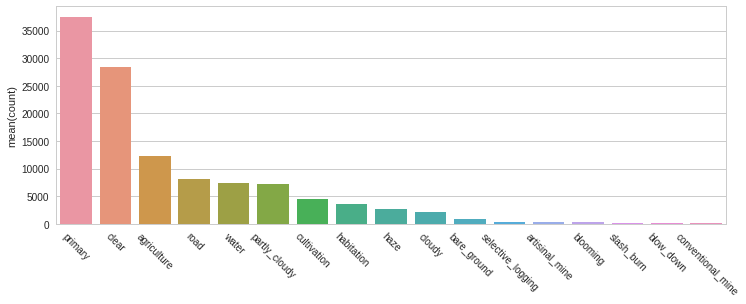

In [4]:
labels = train_df['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

### View some JPEGs

../input/train-tif/train_21.tif
../input/train-tif/train_22.tif
../input/train-tif/train_23.tif
../input/train-tif/train_24.tif
../input/train-tif/train_25.tif
../input/train-tif/train_26.tif
../input/train-tif/train_27.tif
../input/train-tif/train_28.tif
../input/train-tif/train_29.tif


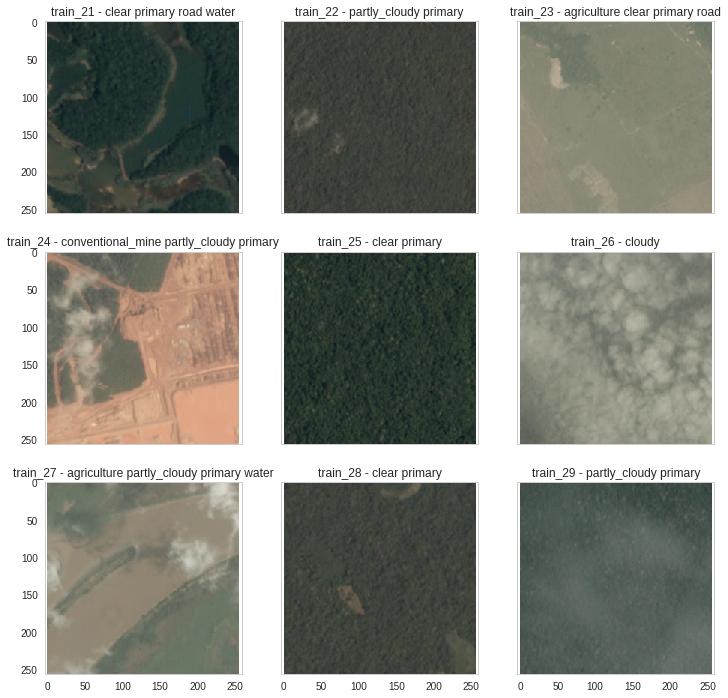

In [5]:
import cv2

new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12, 12))
i = 0
for f, l in train_df[21:30].values:
    img = cv2.imread('../input/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    print('../input/train-tif/{}.tif'.format(f))
    i += 1
    

### Test Image

In [6]:
import skimage
import skimage.io

test_img_f = '../input/train-tif-v2/train_67.tif'
im = skimage.io.imread(test_img_f, plugin='tifffile')
im_g = skimage.io.imread(test_img_f, as_grey=True)

#skimage.io.imshow(im)
im.dtype

dtype('uint16')

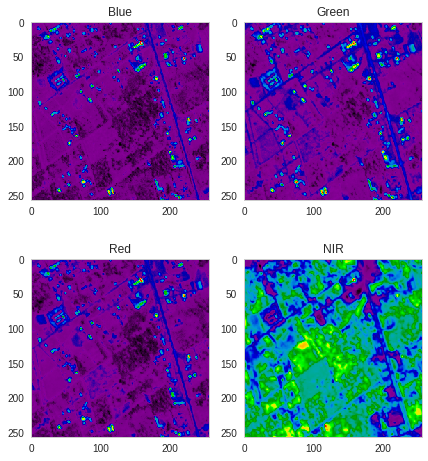

In [7]:
fig, axes = plt.subplots(2,2, figsize=(7, 8))
ax = axes.ravel()

ax[0] = plt.subplot(2, 2, 1, adjustable='box-forced')
ax[0].imshow(im[:,:,0], cmap='nipy_spectral')
for i in range(3):
    ax[i+1] = plt.subplot(2, 2, i+2, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
    ax[i+1].imshow(im[:,:,i+1], cmap='nipy_spectral')
    
ax[0].set_title('Blue')
ax[1].set_title('Green')
ax[2].set_title('Red')
ax[3].set_title('NIR')

### Calculate various indices

USGS Guide on Landsat: https://landsat.usgs.gov/sites/default/files/documents/si_product_guide.pdf

Cloud detection: https://weather.msfc.nasa.gov/sport/journal/pdfs/2009_GRS_Jedlovec.pdf

Water Detection: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4970121/

NDWI: https://en.wikipedia.org/wiki/Normalized_difference_water_index

In [8]:
# RGB and False Color Images
im2 = get_rgb(im, [2, 1, 0]) # RGB
im3 = get_rgb(im, [3, 2, 1]) # NIR-R-G
im4 = get_rgb(im, [3, 2, 0]) # NIR-R-B

# spectral module ndvi function
vi = ndvi(im, 2, 3)

# reverse index
vi1 = (im[:,:,3] - im[:,:,2])/(im[:,:,3] + im[:,:,2])
#vi1 = (im3[:,:,0] - im3[:,:,1])/(im3[:,:,0] + im3[:,:,1])

# calculate NDVI and NDWI with spectral module adjusted bands
vi2 = (im3[:, :, 0] - im3[:, :, 1]) / (im3[:, :, 0] + im3[:, :, 1]) # (NIR - RED) / (NIR + RED)
vi3 = (im3[:, :, 2] - im3[:, :, 0]) / (im3[:, :, 2] + im3[:, :, 0]) # (GREEN - NIR) / (GREEN + NIR)

# EVI
evi=2.5*((im3[:,:,0]-im3[:,:,1])/(im3[:,:,0]+2.4*im3[:,:,1]+1))

# SAVI
savi = ((im3[:,:,0] - im3[:,:,1]) / (im3[:,:,0] + im3[:,:,1] +0.5)) * (1 + 0.5)

# MSAVI Modified Soil Adjusted Vegetation Index 
msavi = (2*im3[:,:,0] + 1 - np.sqrt(np.square(2*im3[:,:,0]+1)-8*(im3[:,:,0]-im3[:,:,1])) )

# NIR Index
mean_vis = np.mean(im2, axis=2)
niri = (mean_vis - im3[:,:,0])/(mean_vis + im3[:,:,0])

### Simple Kmeans clustering from BGRN image

In [9]:
(simple_map, _) = kmeans(im, 3, 10);

Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.0%Iteration 1...1606 pixels reassigned.
Iteration 2...  0.0%Iteration 2...614 pixels reassigned.
Iteration 3...  0.0%Iteration 3...881 pixels reassigned.
Iteration 4...  0.0%Iteration 4...1284 pixels reassigned.
Iteration 5...  0.0%Iteration 5...2230 pixels reassigned.
Iteration 6...  0.0%Iteration 6...4270 pixels reassigned.
Iteration 7...  0.0%Iteration 7...5332 pixels reassigned.
Iteration 8...  0.0%Iteration 8...3829 pixels reassigned.
Iteration 9...  0.0%Iteration 9...2240 pixels reassigned.
Iteration 10...  0.0%Iteration 10...1270 pixels reassigned.
kmeans terminated with 3 clusters after 10 iterations.


### Stats

In [10]:
image_maps = {
    'NDVI_s':vi,
    'Reverse':vi1,
    'NDVI_c':vi2,
    'NDWI':vi3,
    'EVI':evi,
    'SAVI':savi,
    'MSAVI':msavi,
    'NIRI':niri,
    'Simple_class':simple_map
}

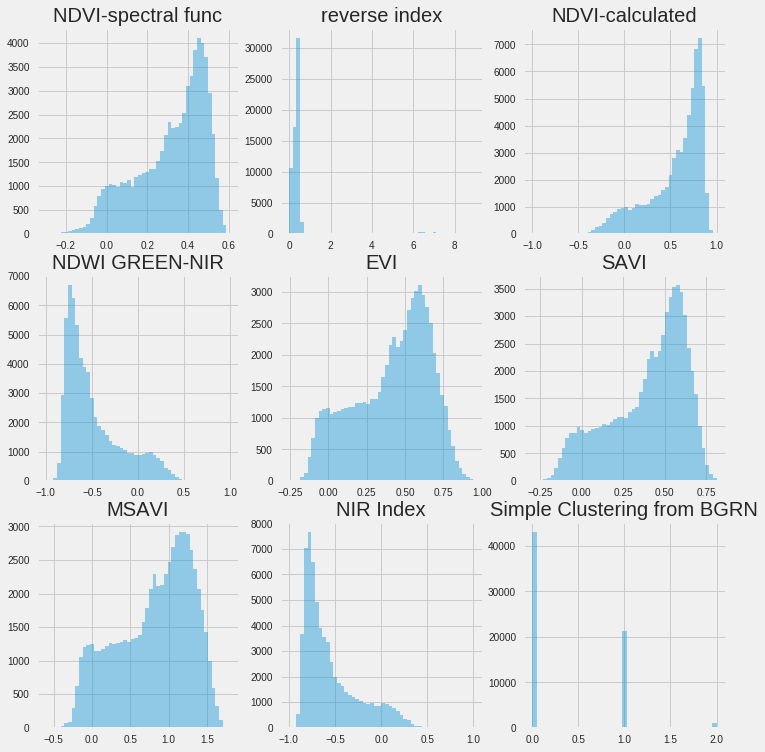

In [11]:
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 12))
ax = axes.ravel()

sns.distplot(vi.flatten(), kde=False, ax=ax[0])
sns.distplot(vi1.flatten(), kde=False, ax=ax[1])
sns.distplot(vi2.flatten(), kde=False, ax=ax[2])
sns.distplot(vi3.flatten(), kde=False, ax=ax[3])
sns.distplot(evi.flatten(), kde=False, ax=ax[4])
sns.distplot(savi.flatten(), kde=False, ax=ax[5])
sns.distplot(msavi.flatten(), kde=False, ax=ax[6])
sns.distplot(niri.flatten(), kde=False, ax=ax[7])
sns.distplot(simple_map.flatten(), kde=False, ax=ax[8])

ax[0].set_title('NDVI-spectral func')
ax[1].set_title('reverse index')
ax[2].set_title('NDVI-calculated')
ax[3].set_title('NDWI GREEN-NIR')
ax[4].set_title('EVI')
ax[5].set_title('SAVI')
ax[6].set_title('MSAVI')
ax[7].set_title('NIR Index')
ax[8].set_title('Simple Clustering from BGRN');

In [12]:
def find_bin_center(i, bin_edges):
    a = bin_edges[i]
    b = bin_edges[i+1]
    return (a+b)/2.0

def find_dist_peak(a, bins=40):
    hist, bin_edges = np.histogram(a,bins)
    b_max = find_bin_center(np.argmax(hist), bin_edges)
    return b_max

map_stats = dict()
for map_name, imap in image_maps.items():
    img_flat = imap.flatten()
    
    map_stats[map_name] = dict(
        peak_dist = find_dist_peak(img_flat,40),
        peak_dist_p = find_dist_peak(img_flat[img_flat>0],40),
        peak_dist_n = find_dist_peak(img_flat[img_flat<0],40),
        mean = np.mean(img_flat),
        median = np.median(img_flat),
        std = np.std(img_flat),
        ptp = np.ptp(img_flat),
    )

print(map_stats['NDVI_s']['peak_dist_p'])

0.447567899701


### Define Texture

(256, 256, 3)

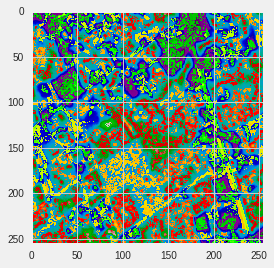

In [13]:
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb

def overlay_labels(image, lbp, labels):
        mask = np.logical_or.reduce([lbp == each for each in labels])
        return label2rgb(mask, image=image, bg_label=0, alpha=0.5)

    
def create_texture_maps(image, radius, METHOD='uniform'):
    n_points = 8 * radius
    image = image + np.abs(np.amin(image))
    
    lbp = local_binary_pattern(image, n_points, radius, METHOD)

    w = width = radius - 1
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                     list(range(i_34 - w, i_34 + w + 1)))
    
    edges = overlay_labels(image, lbp, edge_labels)
    flats = overlay_labels(image, lbp, flat_labels)
    corners = overlay_labels(image, lbp, corner_labels)

    return edges, flats, corners

edges, flats, corners = create_texture_maps(image_maps['EVI'], radius=3, METHOD='uniform')
plt.imshow(flats[:,:,0], cmap='nipy_spectral')
flats.shape
#sns.distplot(flats.flatten(), kde=False)

### View Images

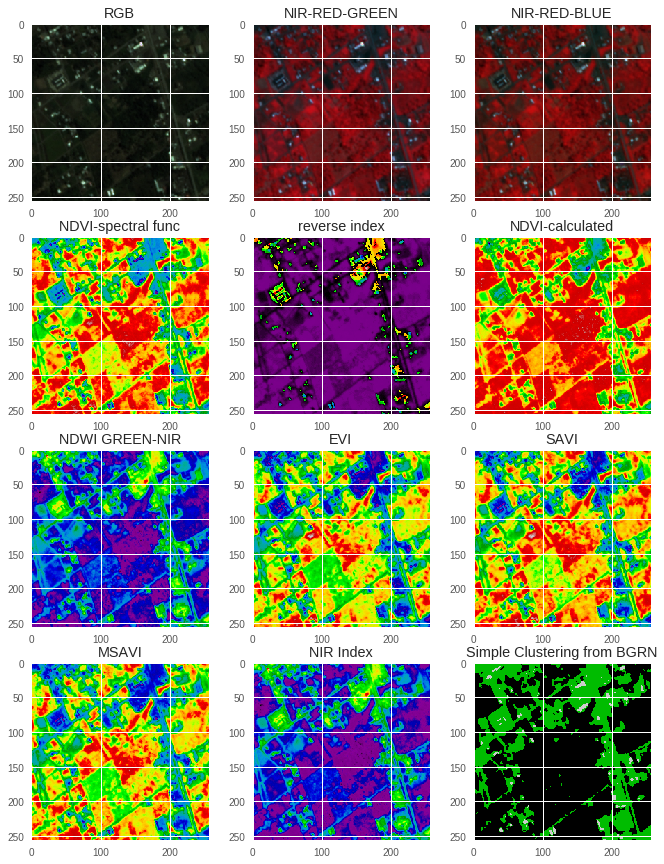

In [14]:
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 14))
ax = axes.ravel()

ax[0] = plt.subplot(4, 3, 1, adjustable='box-forced')
ax[1] = plt.subplot(4, 3, 2, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
ax[2] = plt.subplot(4, 3, 3, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
for i in range(3,12):
    ax[i] = plt.subplot(4, 3, i+1, adjustable='box-forced')
    
ax[0].imshow(im2)
ax[0].set_title('RGB')
ax[1].imshow(im3)
ax[1].set_title('NIR-RED-GREEN')
ax[2].imshow(im4)
ax[2].set_title('NIR-RED-BLUE')

ax[3].imshow(vi, cmap='nipy_spectral') 
ax[3].set_title('NDVI-spectral func')
ax[4].imshow(vi1, cmap='nipy_spectral') 
ax[4].set_title('reverse index')
ax[5].imshow(vi2, cmap='nipy_spectral') 
ax[5].set_title('NDVI-calculated')
ax[6].imshow(vi3, cmap='nipy_spectral') 
ax[6].set_title('NDWI GREEN-NIR')
ax[7].imshow(evi, cmap='nipy_spectral') 
ax[7].set_title('EVI')
ax[8].imshow(savi, cmap='nipy_spectral') 
ax[8].set_title('SAVI')
ax[9].imshow(msavi, cmap='nipy_spectral') 
ax[9].set_title('MSAVI')
ax[10].imshow(niri, cmap='nipy_spectral') 
ax[10].set_title('NIR Index')
ax[11].imshow(simple_map, cmap='nipy_spectral') 
ax[11].set_title('Simple Clustering from BGRN')

### See Edges

4897

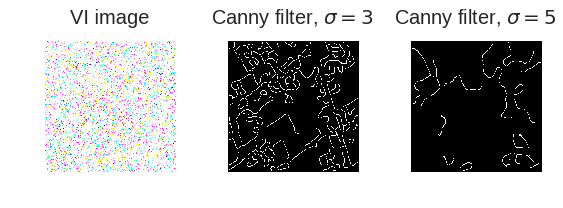

In [15]:
from skimage import feature

# Compute the Canny filter for two values of sigma
test_img = vi
edges1 = feature.canny(test_img, sigma=3)
edges2 = feature.canny(test_img, sigma=5)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('VI image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=3$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=5$', fontsize=20)

fig.tight_layout()
np.sum(edges1)

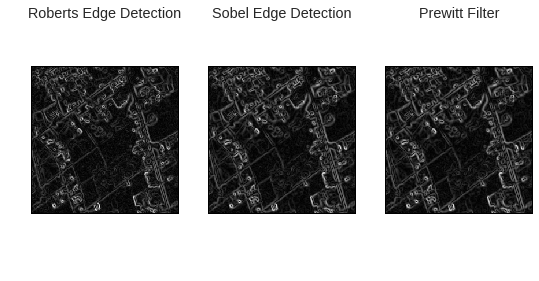

In [16]:
from skimage.filters import roberts, sobel, scharr, prewitt

test_img = vi

edge_roberts = roberts(test_img)
edge_sobel = sobel(test_img)
edge_prewitt = prewitt(test_img)

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,
                       figsize=(8, 4))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[2].set_title('Prewitt Filter')

for a in ax:
    a.axis('off')

### Subtract Dilation

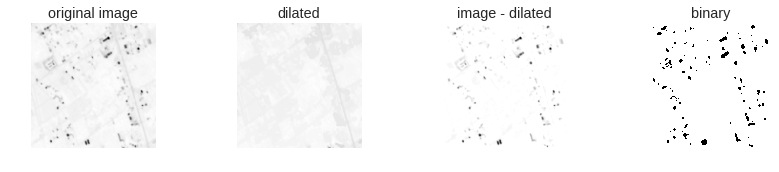

In [17]:
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.filters import threshold_otsu

# Convert to float: Important for subtraction later which won't work with uint8
test_img = im_g
image = img_as_float(test_img)
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')
subtracted = image - dilated

thresh = threshold_otsu(subtracted)
binary = subtracted > thresh

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 2.5), sharex=True, sharey=True)

ax1.imshow(image)
ax1.set_title('original image')
ax1.axis('off')
ax1.set_adjustable('box-forced')

ax2.imshow(dilated, vmin=image.min(), vmax=image.max())
ax2.set_title('dilated')
ax2.axis('off')
ax2.set_adjustable('box-forced')

ax3.imshow(subtracted)
ax3.set_title('image - dilated')
ax3.axis('off')
ax3.set_adjustable('box-forced')

ax4.imshow(binary)
ax4.set_title('binary')
ax4.axis('off')
ax4.set_adjustable('box-forced')

fig.tight_layout()

### Line Detection

Right Angles: 0


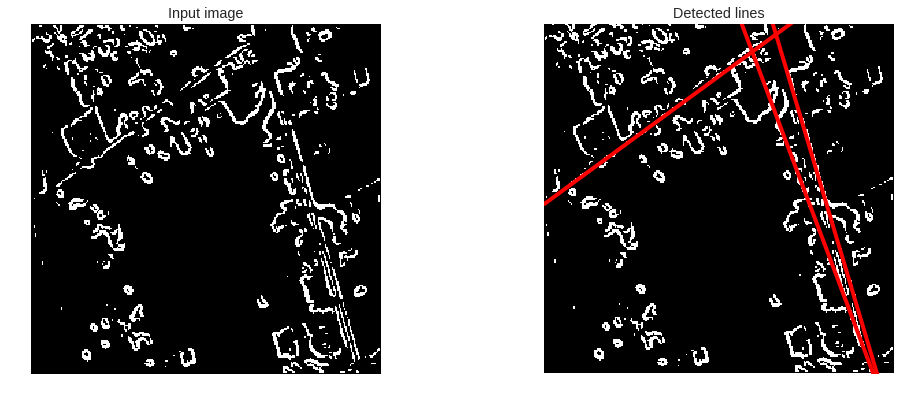

In [18]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage import exposure
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

test_img = im_g # Works well for image 9 to see agg
test_img = vi2 # Works well for image 6 to see agg
test_img = im_g # Works well for image 4 to see agg
test_img = image_maps['NIRI']

contrasted_img = exposure.rescale_intensity(test_img)
edge_sobel = sobel(contrasted_img)
edge_sobel = edge_sobel > np.max(edge_sobel)*0.40

thresh = threshold_otsu(edge_sobel)
binary = edge_sobel > thresh

# Classic straight-line Hough transform
h, theta, d = hough_line(binary)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 6),
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(binary, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(binary, cmap='gray')
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    #print(angle, dist)
    
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[1].plot((0, image.shape[1]), (y0, y1), '-r')
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

angles_list = list(hough_line_peaks(h, theta, d)[1])
sin_diff = np.zeros((len(angles_list), len(angles_list)))
for i, angle_i in enumerate(angles_list):
    for j, angle_j in enumerate(angles_list):
        sin_diff[i, j] = np.sin(angle_i - angle_j)
        
right_angles = len(sin_diff[sin_diff > 0.999])

print('Right Angles: {}'.format(right_angles))

In [19]:
from skimage.restoration import *
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
def find_hough_lines(im, thresh_sobel=0.4, thresh_hough=10, line_length=30, line_gap=3):
    
    edge_sobel = sobel(im)
    edge_sobel = edge_sobel > np.max(edge_sobel)*thresh_sobel

    lines = probabilistic_hough_line(edge_sobel, 
                                     threshold=thresh_hough, 
                                     line_length=line_length,
                                     line_gap=line_gap)
    
    return lines, edge_sobel

In [20]:
def combine_lines(lines, angle_interval=5.0, intercept_interval=15.0):
    angles = []
    intercepts = []
    midpoints = []
    lengths = []
    x0s = []
    x1s = []
    y0s = []
    y1s = []
    for line in lines:
        (x0, y0), (x1, y1) = line
        x0s.append(x0)
        x1s.append(x1)
        y0s.append(y0)
        y1s.append(y1)

        angle = np.rad2deg(np.arctan2(y0 - y1, x0 - x1))
        angles.append(angle)

        slope = (y1 - y0)/(x1 - x0)
        b = y0 - slope*x0
        intercepts.append(b)

        midpoint = (np.mean([x1, x0]), np.mean([y1, y0]))
        midpoints.append(midpoint)

        length = np.sqrt( (x0 - x1)**2 + (y0 - y1)**2 )
        lengths.append(length)

    lines_df = pd.DataFrame(lines, columns=['p0', 'p1'])
    lines_df['x0'] = x0s
    lines_df['x1'] = x1s
    lines_df['y0'] = y0s
    lines_df['y1'] = y1s
    lines_df['angle'] = angles
    lines_df['intercept'] = intercepts
    lines_df['midpoint'] = midpoints
    lines_df['length'] = lengths
    lines_df['angle_round'] = np.round(lines_df['angle']/angle_interval)*angle_interval
    lines_df['intercept_round'] = np.round(lines_df['intercept']/intercept_interval)*intercept_interval
    
    grouped_lines = lines_df.groupby(['angle_round', 'intercept_round'])
    
    max_df = grouped_lines.agg({'length':'max'})
    max_df.reset_index(inplace=True)
    max_df.rename(columns={'length':'length_max'}, inplace=True)
    max_df = pd.merge(lines_df, max_df, how='left', on=['angle_round', 'intercept_round'])
    max_df = max_df[max_df['length'] == max_df['length_max']]
    
    # **** CLEAN THIS UP \/ ****
    minx0_df = grouped_lines.agg({'y0':'min'})
    minx0_df.reset_index(inplace=True)
    minx0_df.rename(columns={'y0':'y0_min'}, inplace=True)
    minx0_df = pd.merge(lines_df, minx0_df, how='left', on=['angle_round', 'intercept_round'])
    minx0_df = minx0_df[minx0_df['y0'] == minx0_df['y0_min']]

    maxx1_df = grouped_lines.agg({'y1':'max'})
    maxx1_df.reset_index(inplace=True)
    maxx1_df.rename(columns={'y1':'y1_max'}, inplace=True)
    maxx1_df = pd.merge(lines_df, maxx1_df, how='left', on=['angle_round', 'intercept_round'])
    maxx1_df = maxx1_df[maxx1_df['y1'] == maxx1_df['y1_max']]
    # **** CLEAN THIS UP /\ ****
    
    new_lines = list(zip(max_df['p0'], max_df['p1']))
    return new_lines

Number of Lines Found: 9


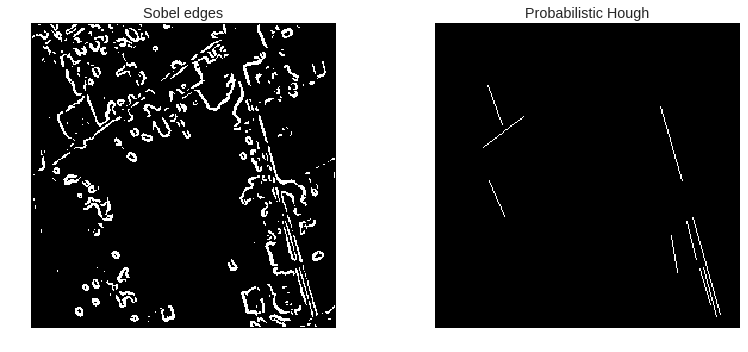

In [21]:
import skimage.draw 

test_img = image_maps['NIRI']
lines, edge_sobel = find_hough_lines(test_img)
lines = combine_lines(lines)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(edge_sobel, cmap='gray')
ax[0].set_title('Sobel edges')

agg_lines = edge_sobel * 0
for line in lines:
    p0, p1 = line
    rr, cc = skimage.draw.line(p0[1], p0[0], p1[1], p1[0])
    line_graph = edge_sobel * 0
    line_graph[rr, cc] = 1
    agg_lines = agg_lines + line_graph
    
ax[1].imshow(agg_lines, cmap='gray')


ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()
    a.set_adjustable('box-forced')

plt.tight_layout()
print('Number of Lines Found: {}'.format(len(lines)))

Take a look at: http://pysptools.sourceforge.net/index.html